In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_mod = gp.create_model('test_model1')

gp.init_data(geo_mod, [0,1000,0,1000,0,1000],resolution=[20,2,200], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

test_model1  2019-07-26 14:06

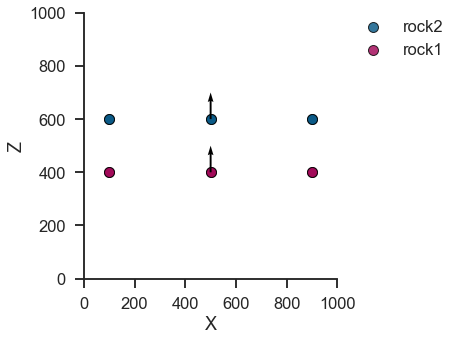

In [3]:
gp.plot.plot_data(geo_mod)

In [4]:
gp.set_interpolation_data(geo_mod, theano_optimizer='fast_run')

Compiling theano function...


/anaconda3/lib/python3.6/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Compilation Done!


In [5]:
gp.compute_model(geo_mod, compute_mesh=False)


Lithology ids 
  [3. 3. 3. ... 1. 1. 1.] 

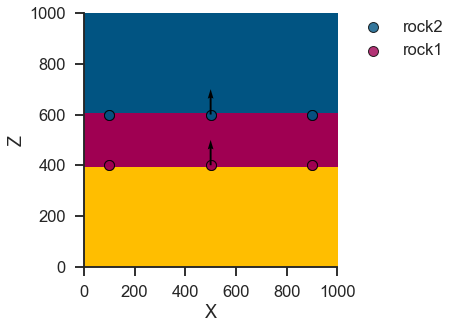

In [6]:
gp.plot.plot_section(geo_mod, cell_number=1, show_data=True)

In [7]:
# Column 10 of the cross-section above
well = geo_mod.solutions.lith_block.reshape(geo_mod.grid.regular_grid.resolution)[10,1,:]
np.round(well)

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
# Computing the thickness in meters
thickness = (np.round(well) == 2).sum()*geo_mod.grid.regular_grid.dz
thickness

210.0

In [9]:
g = geo_mod.surface_points.df.groupby('id')
g.groups[1]

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

In [10]:
geo_mod.modify_surface_points(g.groups[1], Z = 500)


,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series
0,100,200,500,0.2501,0.3126,0.5001,rock2,Default series,1,1
1,500,200,500,0.5001,0.3126,0.5001,rock2,Default series,1,1
2,900,200,500,0.7501,0.3126,0.5001,rock2,Default series,1,1
3,100,800,500,0.2501,0.6876,0.5001,rock2,Default series,1,1
4,500,800,500,0.5001,0.6876,0.5001,rock2,Default series,1,1
5,900,800,500,0.7501,0.6876,0.5001,rock2,Default series,1,1
6,100,200,400,0.2501,0.3126,0.4376,rock1,Default series,2,1
7,500,200,400,0.5001,0.3126,0.4376,rock1,Default series,2,1
8,900,200,400,0.7501,0.3126,0.4376,rock1,Default series,2,1
9,100,800,400,0.2501,0.6876,0.4376,rock1,Default series,2,1


### Simple substraction likelihood. No GemPy involved:

In [11]:
with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
   
    mu = pm.Deterministic('mu', r2-r1)
    a = pm.Normal('y', mu=mu, sd=20, observed=[200])
    trace = pm.sample(10000,
                      step = pm.Metropolis(),
                      compute_convergence_checks=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [rock1]
>Metropolis: [rock2]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:03<00:00, 10779.58draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd030d249b0>,
      dtype=object)

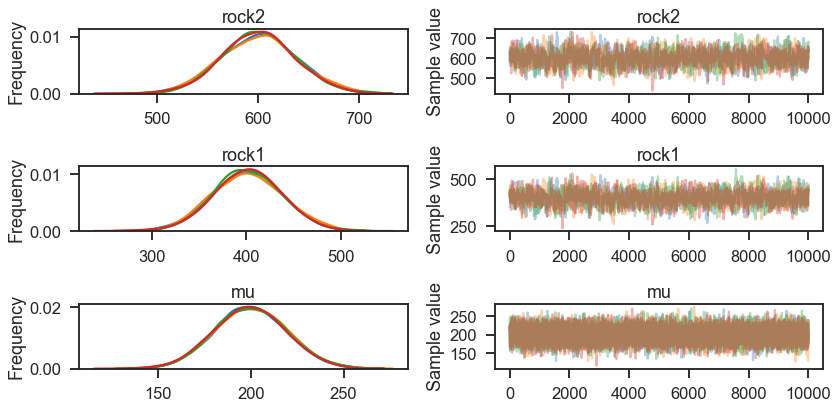

In [12]:
pm.traceplot(trace)

### Creating custom theano functions

Pymc3 only allows to use theano functions. GemPy has been written in theano - among other - for this particular reason. However, theano allows to create custom ops and hence call external functions. For this first notebook lets try to do so for a simple likelihood thickness:

In [15]:
def thickness(l2, l1):
    geo_mod.modify_surface_points(g.groups[1], Z = l2)
    geo_mod.modify_surface_points(g.groups[2], Z = l1)
    #gp.compute_model(geo_data)
    well = geo_mod.solutions.lith_block.reshape(geo_mod.grid.regular_grid.resolution)[10,1,:]
    thickness = (well == 2).sum()*geo_mod.grid.regular_grid.dz
    return thickness
    
    

In [16]:
%%timeit
# Testing the most comvoluted way ever to make a substraction
thickness(800, 200)

35 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now we need to create a theano op that performs the function above:

In [17]:
import theano.tensor as tt

class MuFromTheta(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = thickness(theta[0], theta[1])
        outputs[0][0] = np.array(mu)

# The method allows for passing custom gradients too but we are not going to go down that road quite yet
    
#     def grad(self, inputs, g):
#         theta, = inputs
#         mu = self(theta)
#         thetamu = theta * mu
#         return [- g[0] * mu ** 2 / (1 + thetamu + tt.exp(-thetamu))]

In [31]:
tt_mu_from_theta = MuFromTheta()

In [34]:
ff = tt_mu_from_theta(theta)
mu.tag.test_value

NameError: name 'theta' is not defined

In [60]:
%%timeit
with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    theta = tt.as_tensor_variable([r2, r1])
    mu = pm.Deterministic('mu', tt_mu_from_theta(theta))
    a = pm.Normal('y', mu=mu, sd=20, observed=[200])

181 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    theta = tt.as_tensor_variable([r2, r1])
    mu = pm.Deterministic('mu', tt_mu_from_theta(theta))
    a = pm.Normal('y', mu=mu, sd=20, observed=[200])
    trace = pm.sample(200, step = pm.Metropolis(), tune=50, cores=1, compute_convergence_checks=False)


Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [rock1]
>Metropolis: [rock2]
100%|██████████| 250/250 [01:25<00:00,  2.86it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe689c6e898>,
      dtype=object)

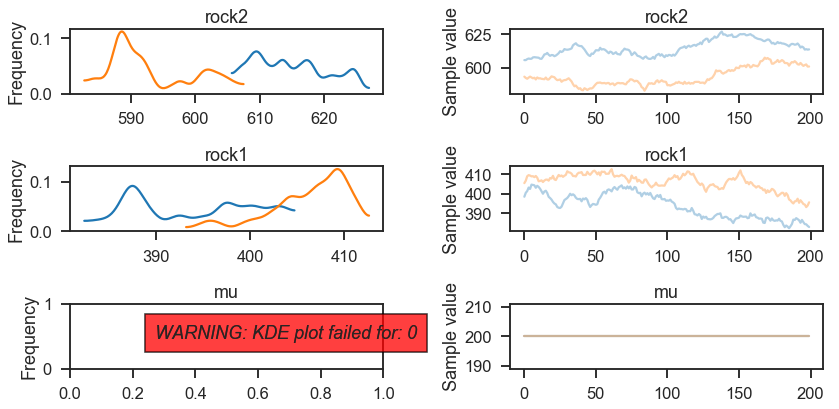

In [61]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe69b866cc0>,
      dtype=object)

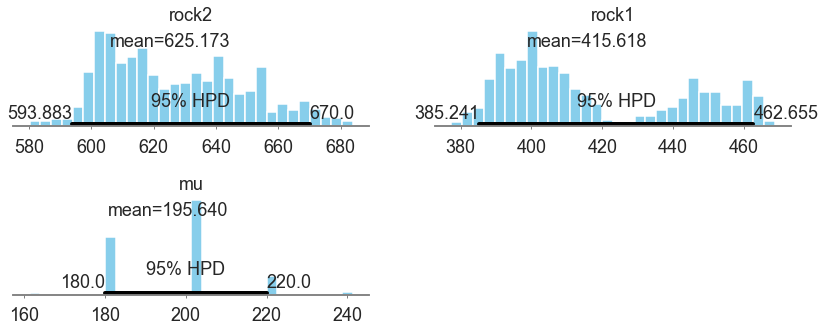

In [37]:
pm.plot_posterior(trace)

## Compiling gempy with PyMC3

In [20]:
import theano
theano.config.compute_test_value = 'ignore'

In [21]:
i = geo_mod.interpolator.get_python_input_block()

In [22]:
geo_model_T = theano.OpFromGraph(geo_mod.interpolator.theano_graph.input_parameters_loop,
                               geo_mod.interpolator.theano_graph.compute_series(), inline=False,
                                 on_unused_input='warn',
                               name='geo_model')

In [23]:
rf = geo_mod.rescaling.df.loc['values', 'rescaling factor']
centers = geo_mod.rescaling.df.loc['values', 'centers']

In [24]:
# This is the new value for rock2
z_rock2 = 700

# We need to rescale
(z_rock2 - centers[2]) / rf + 0.5001

0.6251

In [25]:
# Now we need to change the input of the z of rock 2
i[4][g.groups[1], 2] = (z_rock2 - centers[2]) / rf + 0.5001
i[4]

array([[0.2501, 0.3126, 0.6251],
       [0.5001, 0.3126, 0.6251],
       [0.7501, 0.3126, 0.6251],
       [0.2501, 0.6876, 0.6251],
       [0.5001, 0.6876, 0.6251],
       [0.7501, 0.6876, 0.6251],
       [0.2501, 0.3126, 0.3126],
       [0.5001, 0.3126, 0.3126],
       [0.7501, 0.3126, 0.3126],
       [0.2501, 0.6876, 0.3126],
       [0.5001, 0.6876, 0.3126],
       [0.7501, 0.6876, 0.3126]])

In [26]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'warn'
# We convert a python variable to theano.shared
input_sh = []
for ii in i:
    input_sh.append(theano.shared(ii))

with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)
    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)[0][0][0:8000]
    well = geo.reshape(geo_mod.grid.regular_grid.resolution)[10,1,:]
    thickness = pm.Deterministic('thickness', tt.sum(tt.eq(well, 2)) * geo_mod.grid.regular_grid.dz)
    thickness.name = 'thickness'
    a = pm.Normal('y', mu=thickness, sd=20, observed=120)
    b = pm.Metropolis()
    trace = pm.sample(10000, chains=1,
                     step =b,
                     compute_convergence_checks=True, live_plot=False)

/anaconda3/lib/python3.6/site-packages/theano/gof/op.py:670: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 5 is not part of the computational graph needed to compute the outputs: Full block matrix for faults or drift. We take 2 times len points for the faultdrift..
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  no_recycling=[])
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [rock1]
>Metropolis: [rock2]
100%|██████████| 10500/10500 [04:34<00:00, 38.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd02416e240>,
      dtype=object)

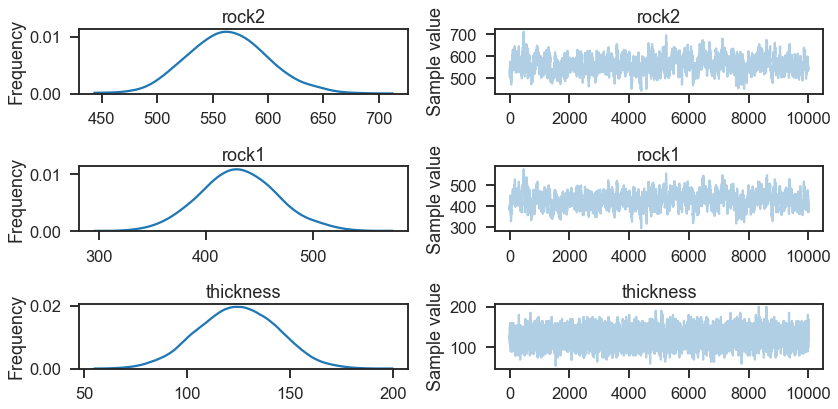

In [27]:
pm.traceplot(trace)

In [28]:
a

y